# Multimodal Idiomaticity Representation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate,Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration, TFBertModel, BertTokenizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

In [ ]:
#Laoding csv files
train_df = pd.read_csv('/content/drive/MyDrive/train/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/val/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test/test.csv')

In [ ]:
# show the data
print (test_df)

             compound sentence_type  \
0         dirty money     idiomatic   
1         dirty money     idiomatic   
2         dirty money     idiomatic   
3        secret santa     idiomatic   
4        secret santa     idiomatic   
5        secret santa     idiomatic   
6         ivory tower     idiomatic   
7         ivory tower     idiomatic   
8         ivory tower     idiomatic   
9   low-hanging fruit     idiomatic   
10  low-hanging fruit     idiomatic   
11  low-hanging fruit     idiomatic   
12         brass ring     idiomatic   
13         brass ring     idiomatic   
14         brass ring     idiomatic   
15      silver bullet     idiomatic   
16      silver bullet     idiomatic   
17      silver bullet     idiomatic   
18      peas in a pod     idiomatic   
19      peas in a pod     idiomatic   
20      peas in a pod     idiomatic   
21        green light     idiomatic   
22        green light     idiomatic   
23        green light     idiomatic   
24           busy bee    

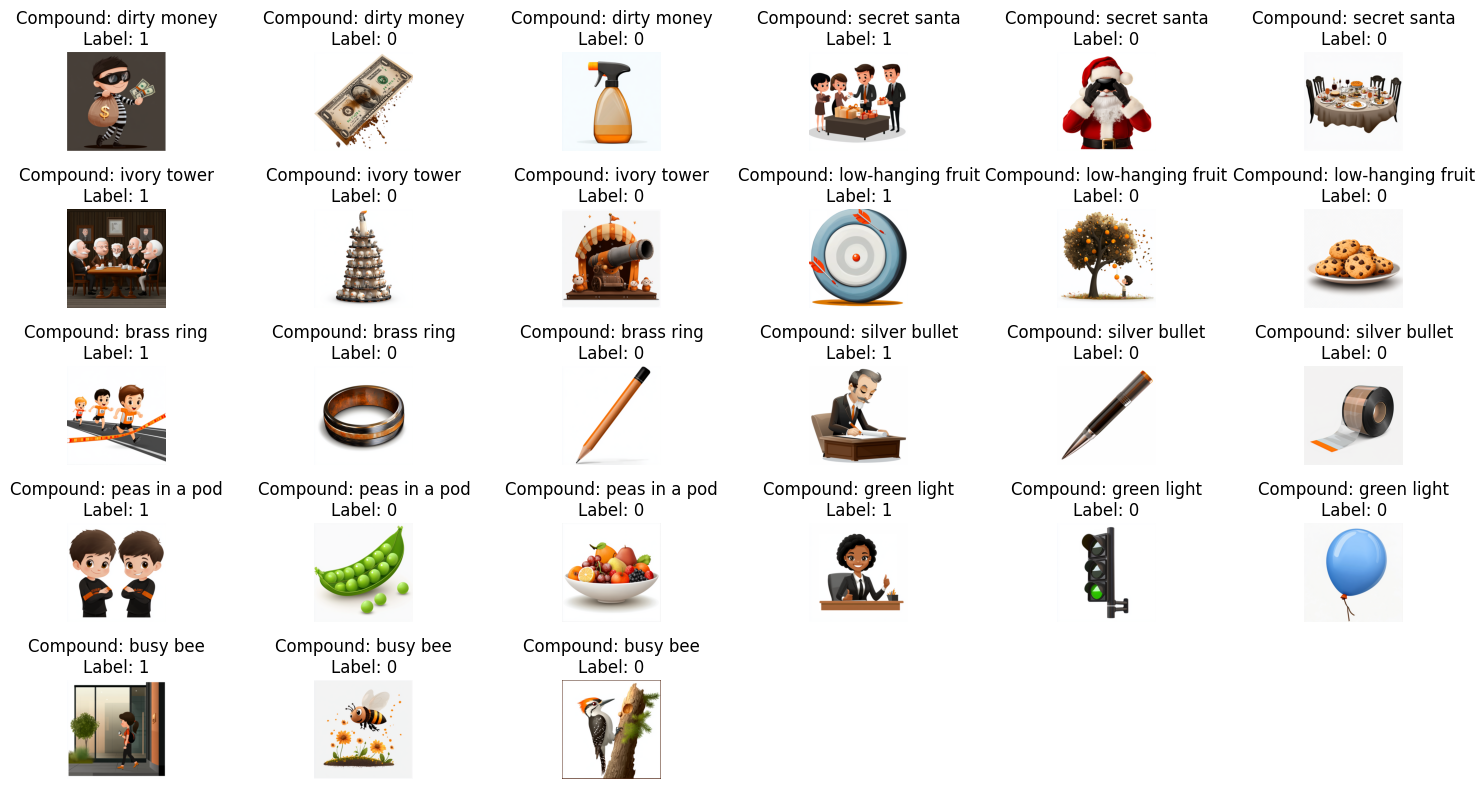

In [ ]:
# Visualise dataset
image_folder = "/content/drive/MyDrive/test/images"

def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(15, 8))
    axes = axes.flatten()

    for idx, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"Compound: {row['compound']}\nLabel: {row['label']}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Hide any empty subplots (those beyond the dataset size)
    for idx in range(len(df), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualise_data(test_df, image_folder)


##  NLP Exploratory Data Analysis

In [ ]:

# Checking and cleaning dataframe from duplicates,checking that each sentence has exatky one correct label and has fixed number of rows(3)
def clean_dataframe(df, expected_rows_per_sentence=3):
    df = df.drop_duplicates(subset=['sentence', 'image_name'])
    label_counts = df.groupby('sentence')['label'].sum()
    valid_sentences = label_counts[label_counts == 1].index
    df = df[df['sentence'].isin(valid_sentences)]
    row_counts = df.groupby('sentence').size()
    valid_sentences = row_counts[row_counts == expected_rows_per_sentence].index
    return df[df['sentence'].isin(valid_sentences)]


train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)


# LLM based Data Augmentation

The data aumentation is performed on the training dataset by generating paraphrased versions of the 'sentence' and 'image_caption' columns.


*   using an LLM (T5) to generate paraphrases
*   unisng a sentence embedding model (Sentence-BERT) to filter them, ensuring they remain semantically close to the originals.



In [ ]:


def data_augmentation_llm(df, num_augmentations=2, similarity_threshold=0.8):

    tokenizer = T5Tokenizer.from_pretrained('t5-base')
    model = T5ForConditionalGeneration.from_pretrained('t5-base')
    similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
    augmented_data = []

    for _, row in df.iterrows():
        sentence = row['sentence']
        caption = row['image_caption']
        input_text = f"paraphrase: {sentence}"

        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids
        outputs = model.generate(input_ids, max_length=50, num_return_sequences=num_augmentations, num_beams=5)
        aug_sentences = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        sentence_embedding = similarity_model.encode(sentence, convert_to_tensor=True)

        for aug_sentence in aug_sentences:
            aug_embedding = similarity_model.encode(aug_sentence, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(sentence_embedding, aug_embedding).item()
            if similarity >= similarity_threshold:
                new_row = row.copy()
                new_row['sentence'] = aug_sentence
                augmented_data.append(new_row)

        #Caption paraphrasing
        input_text = f"paraphrase: {caption}"
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids
        outputs = model.generate(input_ids, max_length=50, num_return_sequences=num_augmentations, num_beams=5)
        aug_captions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        caption_embedding = similarity_model.encode(caption, convert_to_tensor=True)

        for aug_caption in aug_captions:
            aug_embedding = similarity_model.encode(aug_caption, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(caption_embedding, aug_embedding).item()
            if similarity >= similarity_threshold:
                new_row = row.copy()
                new_row['image_caption'] = aug_caption
                augmented_data.append(new_row)

    return pd.concat([df, pd.DataFrame(augmented_data)], ignore_index=True)


train_df_augmented = data_augmentation_llm(train_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Data Preprocessing and Preparation


Tokenizing Text: Converting the 'sentence' and 'image_caption' columns from

*   Tokenizing Text: Converting the 'sentence' and 'image_caption' columns from train_df_augmented into numerical sequences (token IDs and attention masks) that BERT can process.
*   Preprocessing Images: Loading and preprocessing images  for input to EfficientNetB0.
*   Extracting Labels







In [ ]:
# preparing Bert tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def bert_text_to_sequence(texts, max_len=50):
    encodings = bert_tokenizer(texts, truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}



def load_and_preprocess_image(image_name, base_folder):
    image_path = f'{base_folder}/images/{image_name}'
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img


#training data#
#tokenizing sentences
train_encodings = bert_text_to_sequence(train_df_augmented['sentence'].tolist())
#tokenizing captions
train_caption_encodings = bert_text_to_sequence(train_df_augmented['image_caption'].tolist())
#preparing images
images_train = np.array([load_and_preprocess_image(id,  '/content/drive/MyDrive/train') for id in train_df_augmented['image_name']])
#extracing labels
labels_train = train_df_augmented['label'].values

#validation data#
val_encodings = bert_text_to_sequence(val_df['sentence'].tolist())
val_caption_encodings = bert_text_to_sequence(val_df['image_caption'].tolist())
images_val = np.array([load_and_preprocess_image(id,  '/content/drive/MyDrive/val') for id in val_df['image_name']])
labels_val = val_df['label'].values

#test data#
test_encodings = bert_text_to_sequence(test_df['sentence'].tolist())
test_caption_encodings = bert_text_to_sequence(test_df['image_caption'].tolist())
images_test = np.array([load_and_preprocess_image(id,  '/content/drive/MyDrive/test') for id in test_df['image_name']])
labels_test = test_df['label'].values


# Zero-shot prediction


*   Perform Zero-shot Classification: Using a pre-trained natural language inference (NLI) model to evaluate how well an image caption matches a sentence, without training on the dataset.
*   (zero_shot_probs) will be combined with model predictions

*   Evaluate Relevance: For each sentence-caption pair in test_df, it determines the likelihood that the caption describes the sentence’s intended image.




In [ ]:
def zero_shot_prediction(df):

    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    predictions = []

    for _, row in df.iterrows():
        sentence = row['sentence']
        caption = row['image_caption']
        result = classifier(sentence, candidate_labels=[caption, "irrelevant"], hypothesis_template="This Sentence means {}.")
        predictions.append(result['scores'][0])
    return np.array(predictions)

#using the probability obtained by zero_shot to be combined with the model's probablity to shape the overall probability
zero_shot_probs = zero_shot_prediction(test_df)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Fine-tuning based and other prediction approaches

Keras uses symbolic tensors (KerasTensor) during model building, but TFBertModel expects concrete tensors (tf.Tensor). The custom layer handles this gap.

In [ ]:
# Custom Keras layer to wrap TFBertModel
#this is a custom Keras layer that wraps TFBertModel (TensorFlow version of BERT ) to make it compatible with Keras
# Without this wrapper,directly calling TFBertModel within a Keras model can lead to errors because of tensor type mismatches ( KerasTensor vs. tf.Tensor)
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        # inputs is a dictionary with 'input_ids' and 'attention_mask'
        bert_output = self.bert_model(inputs)[0]
        return bert_output

    def get_config(self):
        config = super(BertLayer, self).get_config()
        return config

In [ ]:
projection_dim = 128

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def text_encoder(inputs, name):
    # inputs is a dictionary with 'input_ids' and 'attention_mask'
    bert_layer = BertLayer(bert_model, name=name)
    bert_output = bert_layer(inputs)
    text_embedding = tf.keras.layers.GlobalAveragePooling1D()(bert_output)
    return text_embedding

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# model inputs
context_input_ids = Input(shape=(50,), name='context_input_ids', dtype=tf.int32)
context_attention_mask = Input(shape=(50,), name='context_attention_mask', dtype=tf.int32)
caption_input_ids = Input(shape=(50,), name='caption_input_ids', dtype=tf.int32)
caption_attention_mask = Input(shape=(50,), name='caption_attention_mask', dtype=tf.int32)
image_input = Input(shape=(224, 224, 3), name='image_input')

# encoding texts
context_inputs = {'input_ids': context_input_ids, 'attention_mask': context_attention_mask}
caption_inputs = {'input_ids': caption_input_ids, 'attention_mask': caption_attention_mask}
context_emb = text_encoder(context_inputs, name='context_encoder')
caption_emb = text_encoder(caption_inputs, name='caption_encoder')

#encoding image with EfficientNetB0
efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input)
image_features = GlobalAveragePooling2D()(efficientnet.output)
image_proj = Dense(projection_dim, activation='relu')(image_features)

# combining image and caption embeddings
# merging the image and caption embeddings to represent the image-caption pair as a single vector.
# combining visual and textual information about the image, capturing their joint representation for comparison with the sentence.
image_caption_emb = Concatenate()([image_proj, caption_emb])

# Project embeddings to a common dimension
context_proj = Dense(projection_dim, activation='relu')(context_emb)
image_caption_proj = Dense(projection_dim, activation='relu')(image_caption_emb)

#combining all modalities
combined = Concatenate()([context_proj, image_caption_proj])
#combineing all information and maps it to the binary classification task
output = Dense(1, activation='sigmoid')(combined)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Model(
    inputs=[context_input_ids, context_attention_mask, caption_input_ids, caption_attention_mask, image_input],
    outputs=output
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask'],
     train_caption_encodings['input_ids'], train_caption_encodings['attention_mask'], images_train],
    labels_train,
    validation_data=([val_encodings['input_ids'], val_encodings['attention_mask'],
                      val_caption_encodings['input_ids'], val_caption_encodings['attention_mask'], images_val], labels_val),
    epochs=10,
    batch_size=32,
    callbacks=[lr_callback, early_stopping],
    verbose=1
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7089 - loss: 0.5923 - val_accuracy: 0.6296 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9124 - loss: 0.2440 - val_accuracy: 0.7037 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9494 - loss: 0.1036 - val_accuracy: 0.6296 - val_loss: 1.7435 - learning_rate: 0.0010
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9811 - loss: 0.0827 - val_accuracy: 0.5185 - val_loss: 1.7840 - learning_rate: 0.0010


In [ ]:
# prediction on test set
test_probs = model.predict(
    [test_encodings['input_ids'], test_encodings['attention_mask'],
     test_caption_encodings['input_ids'], test_caption_encodings['attention_mask'], images_test]
)

#ensuring test_probs and zero_shot_probs is a 1D array
test_probs = test_probs.squeeze()
zero_shot_probs = zero_shot_probs.squeeze()

# ensembling with zero-shot predictions
ensemble_probs = 0.7 * test_probs + 0.3 * zero_shot_probs

test_df['prob'] = ensemble_probs
predicted = test_df.groupby('sentence').apply(lambda x: x['image_name'].iloc[x['prob'].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


<ipython-input-16-6053acbb32df>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predicted = test_df.groupby('sentence').apply(lambda x: x['image_name'].iloc[x['prob'].argmax()])


# Evaluation

In [ ]:
# Get true image names where label == 1
true = test_df[test_df['label'] == 1].set_index('sentence')['image_name']

predicted_labels = (ensemble_probs > 0.5).astype(int).flatten()
f1 = f1_score(labels_test, predicted_labels, average='macro')
precision= precision_score(labels_test, predicted_labels, average='macro')
recall= recall_score(labels_test, predicted_labels, average='macro')
accuracy=accuracy_score(labels_test, predicted_labels)

print(f'Test F1 Score       : {f1:.4f}')
print(f'Test Precision Score: {precision:.4f}')
print(f'Test Recall Score   : {recall:.4f}')
print(f'Test Accuracy Score : {accuracy:.4f}')


Test F1 Score       : 0.8782
Test Precision Score: 0.8706
Test Recall Score   : 0.8889
Test Accuracy Score : 0.8889


# Displaying True and Predicted Images

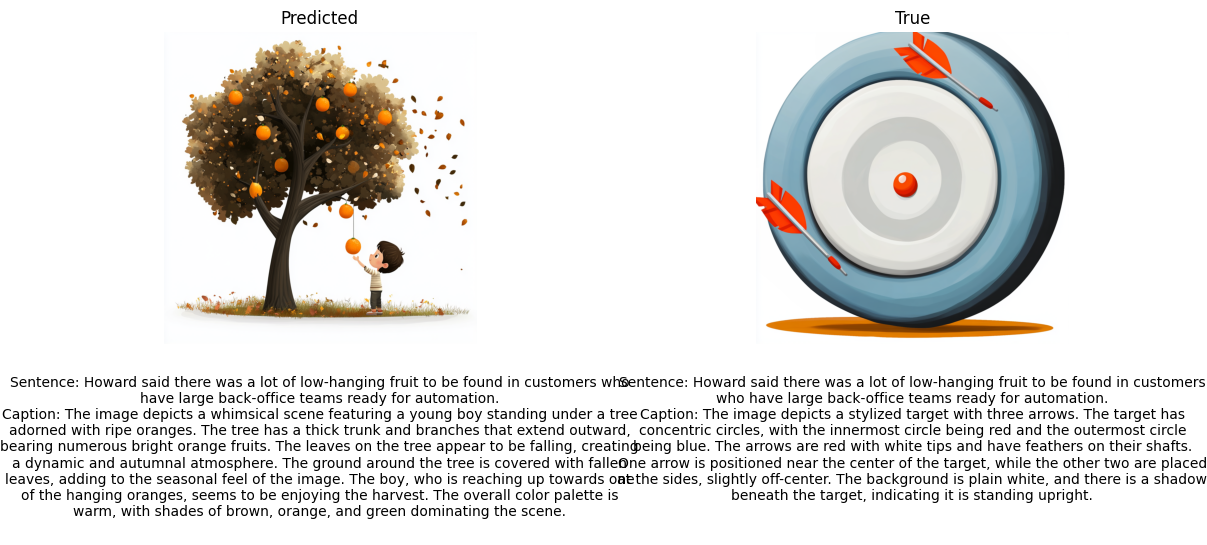

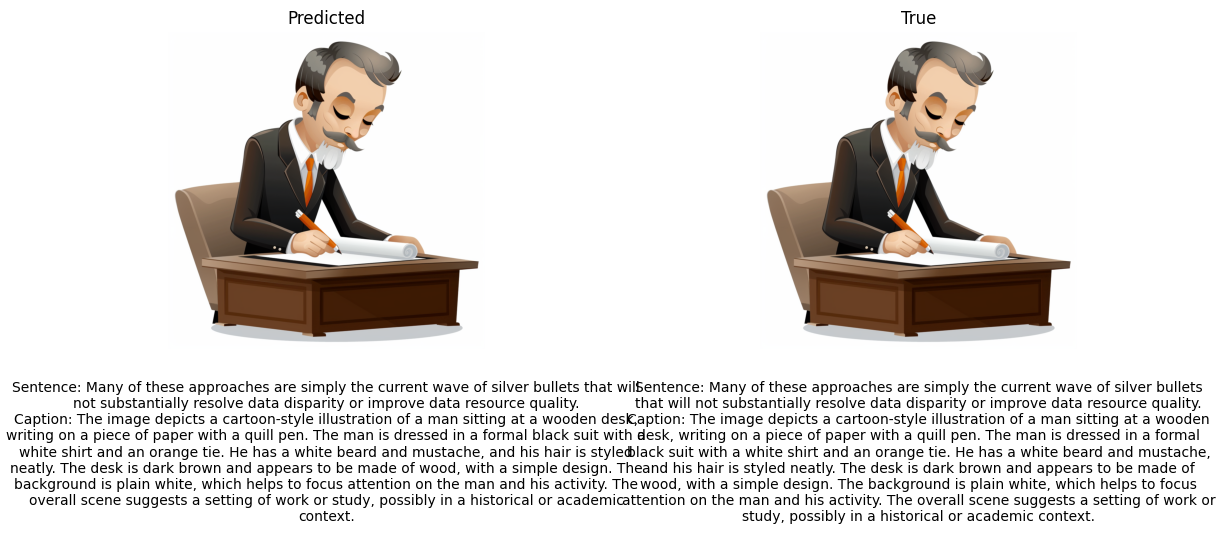

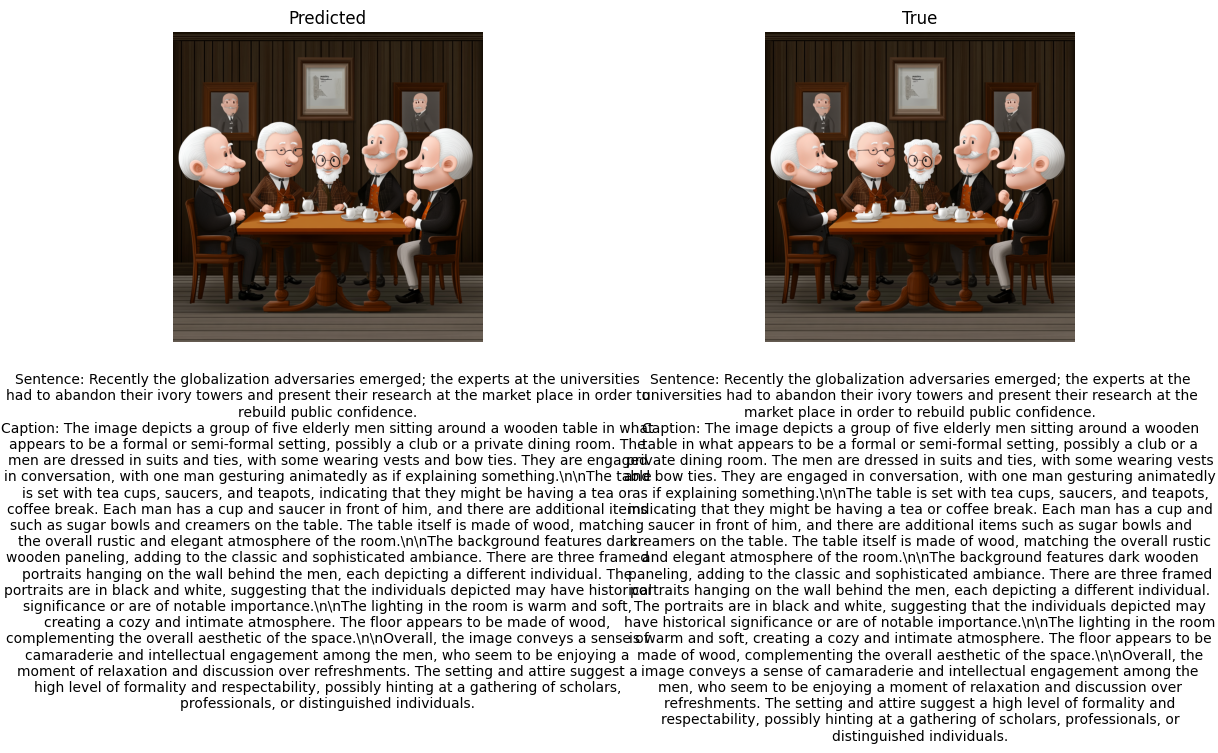

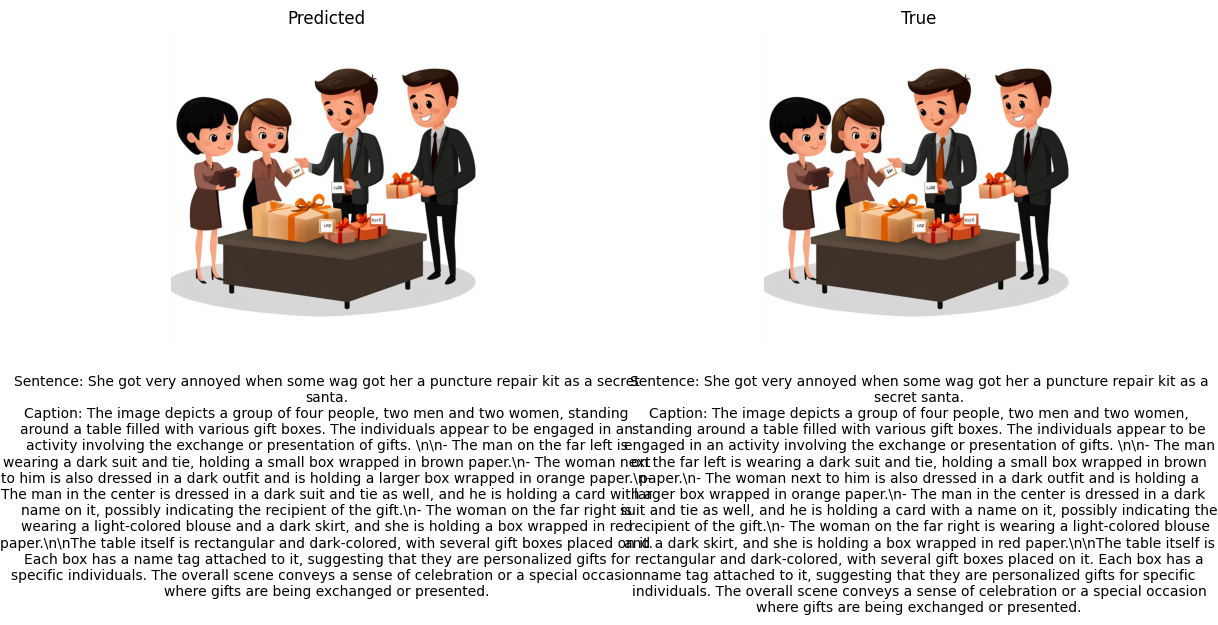

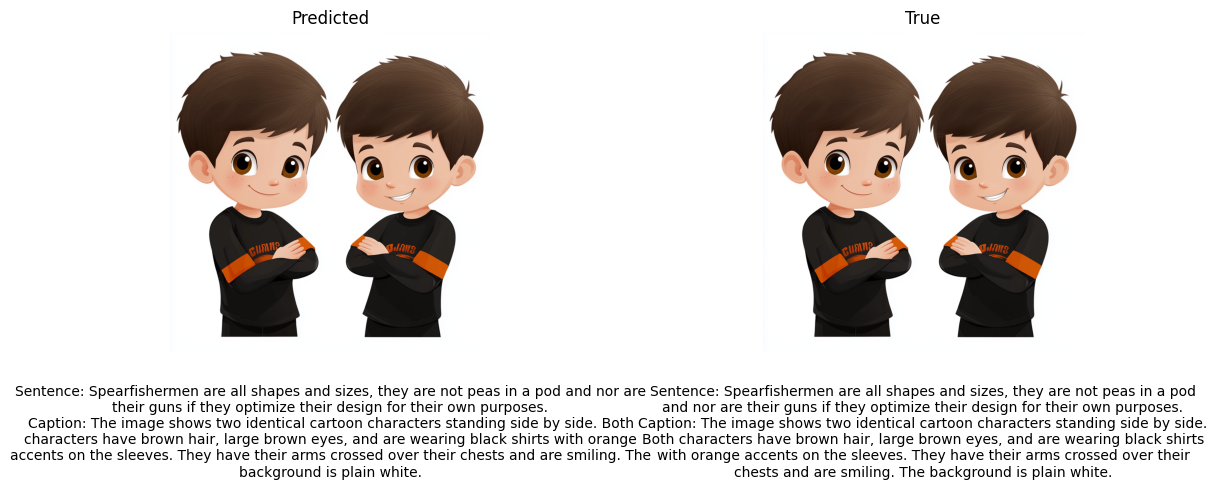

In [ ]:
import matplotlib.pyplot as plt

def load_image_for_display(image_name, base_folder):
    image_path = f'{base_folder}/images/{image_name}'
    return load_img(image_path)



def display_predicted_vs_true(test_df, predicted, true, base_folder='/content/drive/MyDrive/test', num_samples=5):
    pred_df = pd.DataFrame({'sentence': predicted.index, 'pred_image_name': predicted.values})
    true_df = pd.DataFrame({'sentence': true.index, 'true_image_name': true.values})
    merged_df = pred_df.merge(true_df, on='sentence', how='inner')
    merged_df = merged_df.merge(test_df[['sentence', 'image_name', 'image_caption']],
                                left_on=['sentence', 'pred_image_name'],
                                right_on=['sentence', 'image_name'],
                                how='left',
                                suffixes=('', '_pred'))
    merged_df = merged_df.merge(test_df[['sentence', 'image_name', 'image_caption']],
                                left_on=['sentence', 'true_image_name'],
                                right_on=['sentence', 'image_name'],
                                how='left',
                                suffixes=('_pred', '_true'))

    sample_df = merged_df.head(num_samples)

    for idx, row in sample_df.iterrows():
        pred_image = load_image_for_display(row['pred_image_name'], base_folder)
        true_image = load_image_for_display(row['true_image_name'], base_folder)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

        # Predicted images
        ax1.imshow(pred_image)
        ax1.set_title('Predicted')
        ax1.axis('off')
        pred_text = f"Sentence: {row['sentence']}\nCaption: {row['image_caption_pred']}"
        ax1.text(0.5, -0.1, pred_text, ha='center', va='top', transform=ax1.transAxes, wrap=True)

        # True images
        ax2.imshow(true_image)
        ax2.set_title('True')
        ax2.axis('off')
        true_text = f"Sentence: {row['sentence']}\nCaption: {row['image_caption_true']}"
        ax2.text(0.5, -0.1, true_text, ha='center', va='top', transform=ax2.transAxes, wrap=True)

        plt.tight_layout()
        plt.show()


display_predicted_vs_true(test_df, predicted, true)